In [1]:
import numpy as np
import matplotlib.pyplot as plt
from methods import *

a) Legendre Collocation Method

Text(0, 0.5, 'Relative error')

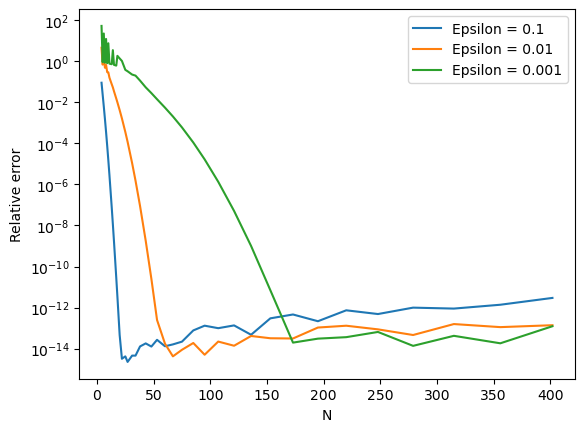

In [3]:
def true_u(x,eps):
    return (np.exp(-x/eps)+(x-1)-np.exp(-1/eps)*x)/(np.exp(-1/eps)-1)
true_u = np.vectorize(true_u)
plot_approximations = False
epsilons = [0.1,0.01,0.001]
Ns = [10,20,50,100,200,500]
Ns = np.ceil(np.logspace(0,2.6,50))+3
rel_err = []
for eps in epsilons:
    for N in Ns:
        N = int(N)
        xGL = JacobiGL(0,0,N)
        ys = (xGL+1)/2
        dV = GradJacobiP(xGL,0,0,N,matrix=True)
        V = JacobiP(xGL,0,0,N,matrix=True).T
        Vi = np.linalg.inv(V)
        D = dV@Vi*2
        # if N == 10:
        #     print(D)
        #D = Dmatrix_Legendre(N,xGL,0,1)
        LN = -eps*D@D-D
        LN[0,:] = np.concatenate(([1],np.zeros(N)))
        LN[-1,:] = np.concatenate((np.zeros(N),[1]))
        f_tilde = np.concatenate(([0],np.ones(N-1),[0]))
        u_hat = np.linalg.solve(LN,f_tilde)
        rel_err.append(np.linalg.norm(u_hat-true_u(ys,eps))/(np.linalg.norm(true_u(ys,eps))))
        if N == 20 and plot_approximations:
            plt.figure()
            fine_grid = (JacobiGL(0,0,500)+1)/2
            plt.plot(fine_grid,true_u(fine_grid,eps), label="True solution")
            plt.plot(ys,u_hat,'o',label="Approximation")
            plt.xlabel("x")
            plt.title(f"Epsilon = {eps}")
            plt.legend()
plt.figure()
plt.semilogy(Ns,rel_err[0:len(Ns)],label=f"Epsilon = {epsilons[0]}")
plt.semilogy(Ns,rel_err[len(Ns):2*len(Ns)],label=f"Epsilon = {epsilons[1]}")
plt.semilogy(Ns,rel_err[2*len(Ns):(3*len(Ns))],label=f"Epsilon = {epsilons[2]}")
plt.legend()
plt.xlabel("N")
plt.ylabel("Relative error")

Legendre Tau Method

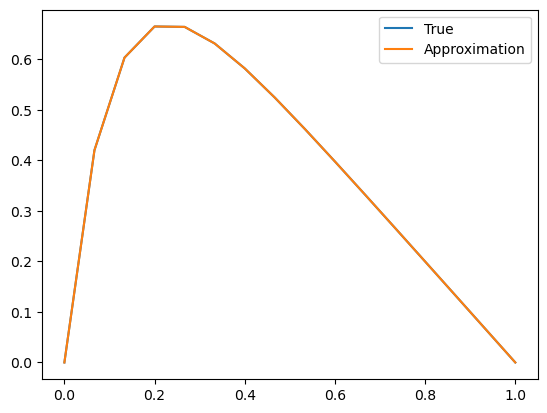

In [4]:
m = 16
#X = np.arange(m)/m*2 - 1
X = np.linspace(0,1,m)
eps = 0.1
testsol = LTM_2ord((X*2)-1, m, -eps*4, -2,None)

plt.figure
plt.plot(X,true_u(X,eps),label="True")
plt.plot(X,testsol,label="Approximation")
plt.legend()
plt.show()

Part b)

Text(0, 0.5, 'Relative error')

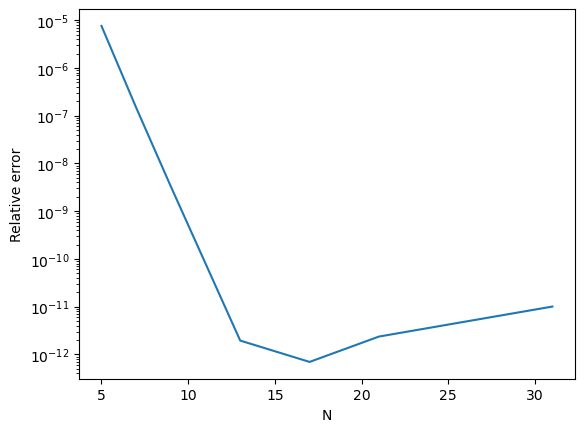

In [4]:
def true_phi(r,theta):
    return (r+1/r)*np.cos(theta)

plot_example = False
rel_errors = []
Ns = np.array([4,6,8,12,16,20,30])
Ns = Ns+1 # Need uneven for our Fourier matrix to work
for N in Ns:
    
    ### r - direction
    x_r = JacobiGL(0,0,N-1) 
    X_r = (x_r+3)/2
    D_r = Dmatrix_Legendre(N-1,x_r,1,2)

    ### theta - direction
    x_theta = [2*np.pi*j/(N-1) for j in range(N-1)] 
    X_theta = np.concatenate([x_theta,[2*np.pi]]) # Include boundary point
    D_theta = Dmatrix_Fourier(N-1,x_theta)
    D_theta = np.vstack([D_theta,D_theta[0]])
    D_theta = np.c_[D_theta,np.zeros(N)] # again to include boundary point

    ### 2d matrices
    Dtheta_2d = np.kron(D_theta,np.identity(N))
    Dr_2d = np.kron(np.identity(N),D_r)
    I_r = np.kron(np.identity(N),np.diag(1/X_r))
    LN = I_r@Dr_2d + Dr_2d@Dr_2d + I_r@I_r@Dtheta_2d@Dtheta_2d
    RHS = np.zeros(N**2)
    
    ### Boundary conditions
    for i in range(N):
        index = N*i
        b1 = np.zeros(N**2)
        b1[index] = 1
        LN[index,:] = b1
        RHS[index] = 2*np.cos(X_theta[i])
        ##
        index = (N-1) + N*i
        b1 = np.zeros(N**2)
        b1[index] = 1
        LN[index,:] = b1
        RHS[index] = 2.5*np.cos(X_theta[i])
        ##
        index = i
        b1 = np.zeros(N**2)
        b1[index] = 1
        LN[index,:] = b1
        RHS[index] = X_r[i]+1/X_r[i]
        ##
        index = (N-1)*N + i
        b1 = np.zeros(N**2)
        b1[index] = 1
        LN[index,:] = b1
        RHS[index] = X_r[i]+1/X_r[i]

    u_hat = np.linalg.solve(LN,RHS)
    r,theta = np.meshgrid(X_r, X_theta)
    true_sol = true_phi(r,theta)
    u_hat = u_hat.reshape((N,N))
    rel_errors.append(np.linalg.norm(true_sol - u_hat)/np.linalg.norm(true_sol))
    if N == 6 and plot_example:
        print("rel error")
        print(np.linalg.norm(true_sol - u_hat)/np.linalg.norm(true_sol))
        print("True")
        print(true_sol)
        print("Uhat")
        print(u_hat)
    
plt.figure()
plt.semilogy(Ns,rel_errors)
plt.xlabel("N")
plt.ylabel("Relative error")